# COSTRUZIONE DI UN NOISE MODEL

Nell'esercizio si è utilizzato un Noise Model preso da un fake provider, che simulasse una backend reale con FakeManilaV2. Tuttavia le curve ottenute (riportate nelle seguenti celle) sono particolarmente "buone", nel senso che non sembrano essere affette da un noise reale plausibile. Ad esempio nella curva a 4 step il fatto che questa arrivi per t = 3.14 a 0 e non "poco piu' sopra" è strano.
Per effettuare una migliore analisi si è costruito un Noise Model utilizzando le funzioni di qiskit-aer, basate sulla teoria delle quantum operations che descrivessero i diversi tipi di noise come quantum channel che simulassero l'ambiente (la documentazione utilizzata è il Nielsen, Chuang).

## LE CURVE CON FAKE BACKEND

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la


from qiskit import QuantumCircuit, transpile
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.primitives import StatevectorEstimator, BackendEstimatorV2 as BackendEstimator
from qiskit_ibm_runtime import QiskitRuntimeService
 

from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit_aer.noise import (QuantumError, depolarizing_error, amplitude_damping_error, phase_damping_error, pauli_error)
from qiskit.providers import Options



In [25]:
#Rendiamo generale la funzione, prende N numero di Spin, t il tempo, j il primo spin e i il secondo spin (questi saranno j e j+1 in quanto nearest neighbours)
def R_zz(N, t, j, i):
    
    ZZ_qc = QuantumCircuit(N)

    ZZ_qc.cx(j,i)
    ZZ_qc.rz(2 * t, i) #vedi definizione sopracitata per il fattore 2
    ZZ_qc.cx(j,i)

    return ZZ_qc

#decomponiamo il Rot. Gate XX
def R_xx(N, t, j, i):

    XX_qc = QuantumCircuit(N)

    XX_qc.ry(np.pi/2,[j,i])
    XX_qc.cx(j,i)
    XX_qc.rz(2 * t, i)
    XX_qc.cx(j,i)
    XX_qc.ry(-np.pi/2,[j,i])

    return XX_qc

#decomponiamo il Rot. Gate YY
def R_yy(N, t, j, i):
    YY_qc = QuantumCircuit(N)
    
    YY_qc.rx(np.pi/2,[j,i])
    YY_qc.cx(j,i)
    YY_qc.rz(2 * t, i)
    YY_qc.cx(j,i)
    YY_qc.rx(-np.pi/2,[j,i])

    return YY_qc


In [26]:
#definiamo l'hamiltoniana
def H_Heis(N):
    #usiamo J = 1
    XX_tuples = [("XX", [i, i + 1], 1) for i in range(0, N-1)]
    YY_tuples = [("YY", [i, i + 1], 1) for i in range(0, N-1)]
    ZZ_tuples = [("ZZ", [i, i + 1], 1) for i in range(0, N-1)]

    #col metodo from_sparse_list di SparsePauliOp definiamo l'hamiltoniana
    hamiltonian = SparsePauliOp.from_sparse_list([*XX_tuples, *YY_tuples, *ZZ_tuples], N)

    return hamiltonian

#definiamo l'evoluzione temporale nel caso classico
def U_Heis(n_spins,t):
    H = H_Heis(n_spins).to_matrix()
    return la.expm(-1j*t*H)

In [27]:
def Heisenberg_Trotter(num_spins, trotter_steps, t):
    #definiamo un time step dt
    dt = (t)/(trotter_steps) 

    #creiamo il quantumcircuit
    qc_t = QuantumCircuit(num_spins)

    #iteriamo su ogni time step
    for i in range(trotter_steps):
        #iteriamo su ogni spin
        for j in range(0, num_spins -1):
            #implementazione dei gate è uguale al caso precedente, in quanto operiamo su coppie di spin
            qc_t = qc_t.compose(R_xx(num_spins,dt,j,j+1))
            qc_t = qc_t.compose(R_yy(num_spins,dt,j,j+1))
            qc_t = qc_t.compose(R_zz(num_spins,dt,j,j+1))

        
        #qc.barrier()

    return qc_t

4 steps completed
8 steps completed
12 steps completed


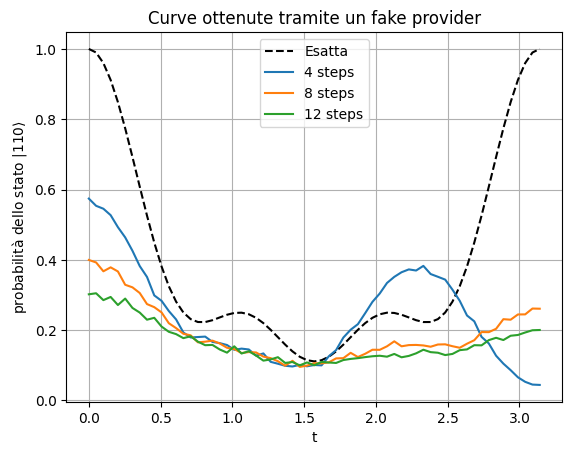

In [28]:
#LE CURVE AFFETTE DAL NOISE DI FAKE MANILA

#definiamo il numero di time steps
t_steps = 63 #così ogni step è di 0.05

#definiamo il tempo in cui facciamo evolvere il sistema
dt = np.pi

#generiamo una spaziatura lineare di t_steps nell'intervallo [0, pi]
ts = np.linspace(0, dt, t_steps) 

from qiskit_ibm_runtime.fake_provider import FakeMontrealV2
QiskitRuntimeService.save_account(channel="ibm_quantum", token="982082508a1c98ca02cb712c6751b42ef860d905b080b3bfc02ef35d68d84441803586912cbcf181e1e72ebc8569103421b06c25408fe8134975a72575c4d637", overwrite= True)


probs_110_trott = {4:[],8:[],12:[]}
initial_state = Statevector.from_label('011').data
probs_110 = [np.abs((initial_state @ U_Heis(3,float(t)) @ initial_state))**2 for t in ts]

fake_backend = FakeMontrealV2()
estimator = BackendEstimator(backend=fake_backend)
pm = generate_preset_pass_manager(optimization_level=0) #non ottimizziamo (stiamo costruendo un modello di rumore)

#misuriamo |110><110|
prj_zero = SparsePauliOp.from_list([("I", 1/2), ("Z", 1/2)])
prj_one = SparsePauliOp.from_list([("I", 1/2), ("Z", -1/2)])
prj = prj_one ^ prj_one ^ prj_zero



#iteriamo sui differenti valori di step di trotter
for n in probs_110_trott.keys():
    #evolviamo nel tempo
    for sim_t in ts:
        qc = QuantumCircuit(3)
        #buildiamo lo stato
        qc.x(1)
        qc.x(2)
        
        trott_steps = Heisenberg_Trotter(num_spins=3,trotter_steps=n,t=sim_t)
        
        qc = qc.compose(trott_steps)

        
        isa_circuit = pm.run(qc)
        isa_observable = prj.apply_layout(isa_circuit.layout)
        trotter_result = estimator.run([(isa_circuit, isa_observable)]).result()
        trotter_value = trotter_result[0].data.evs
        probs_110_trott[n].append(trotter_value.mean().real)
        #print(trotter_value.mean().real)
    
    print(str(n)+" steps completed")


#plottiamo
plt.plot(ts, probs_110,linestyle="dashed",color="black",label="Esatta")
for (i,n) in enumerate(probs_110_trott.keys()):
    plt.plot(ts, probs_110_trott[n],color="C"+str(i),label=str(n)+" steps")
plt.xlabel('t')
plt.ylabel(r'probabilità dello stato $|110\rangle$')
plt.title(r'Curve ottenute tramite un fake provider')
plt.legend()
plt.grid()
plt.savefig('../../png/noise2/0_fakebackend.png')
plt.show()

## con Noise Model

Per la documentazione su qiskit-aer: https://qiskit.github.io/qiskit-aer/tutorials/3_building_noise_models.html

In [29]:
from qiskit_aer.noise import (QuantumError, depolarizing_error, amplitude_damping_error, phase_damping_error, pauli_error)

### BIT-FLIP E PHASE-FLIP


Il bit-flip è un errore che introduce una probabilità 1-p che un qubit in uno stato 0,1 venga flippato, ovvero che passi da 0-1 o da 1-0. 
Usando il formalismo delle quantum operations, con $E_k$ gli elementi dell'operazione, si ha che 
\begin{equation}
E_0 = \sqrt{p}\cdot I, \ E_1 = \sqrt{1-p}\cdot X
\end{equation}
mentre per il phase-flip introduce una probabilità che il qubit flippi lungo l'asse Z e dunque cambi segno da + a -.

Introduciamo una probabilità di flippare sia bit che phase del 5% 

In [30]:
noise_model = NoiseModel()

p_flip = 0.05
bit_flip = pauli_error([('X', p_flip), ('I', 1 - p_flip)])
phase_flip = pauli_error([('Z', p_flip), ('I', 1 - p_flip)])

#componiamoli in un unico errore
bitphase_flip = bit_flip.compose(phase_flip)

#aggiungiamolo al noise model, in modo che agiscano su tutti i qubit
noise_model.add_all_qubit_quantum_error(bitphase_flip, ['u1', 'u2', 'u3'])

4 steps completed
8 steps completed
12 steps completed


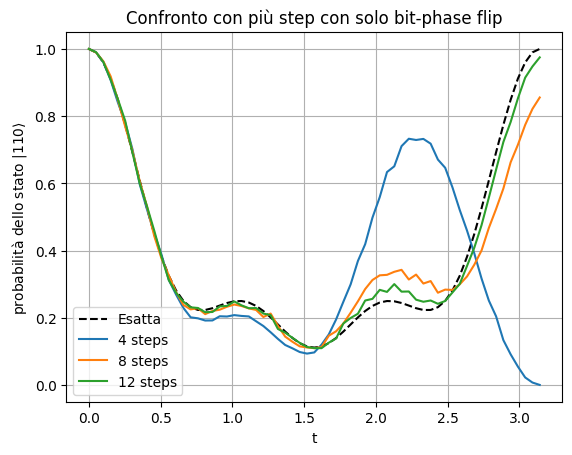

In [31]:
#disegniamo le curve
probs_110_trott = {4:[],8:[],12:[]}
simulator = AerSimulator(noise_model=noise_model)
estimator = BackendEstimator(backend=simulator)
pm = generate_preset_pass_manager(optimization_level=0)
for n in probs_110_trott.keys():
    #evolviamo nel tempo
    for sim_t in ts:
        qc = QuantumCircuit(3)
        #buildiamo lo stato
        qc.x(1)
        qc.x(2)
        
        trott_steps = Heisenberg_Trotter(num_spins=3,trotter_steps=n,t=sim_t)
        
        qc = qc.compose(trott_steps)

        
        isa_circuit = pm.run(qc)
        isa_observable = prj.apply_layout(isa_circuit.layout)
        trotter_result = estimator.run([(isa_circuit, isa_observable)]).result()
        trotter_value = trotter_result[0].data.evs
        probs_110_trott[n].append(trotter_value.mean().real)
        #print(trotter_value.mean().real)
    
    print(str(n)+" steps completed")

#plottiamo
plt.plot(ts, probs_110,linestyle="dashed",color="black",label="Esatta")
for (i,n) in enumerate(probs_110_trott.keys()):
    plt.plot(ts, probs_110_trott[n],color="C"+str(i),label=str(n)+" steps")
plt.xlabel('t')
plt.ylabel(r'probabilità dello stato $|110\rangle$')
plt.title(r'Confronto con più step con solo bit-phase flip')
plt.legend()
plt.grid()
plt.savefig('../../png/noise2/1_bitphase1.png')
plt.show()

### BITPHASE-FLIP RIELABORATO

Utilizziamo un modello più raffinato che usi tuttavia solamente il bitphase-flip sopracitato, ma in modo diverso

1) su gate a singolo qubit, flippiamo con prob p_gate1;
2) applicando un gate a due qubit, applica il p_gate1 a ciascun qubit;
3) se si resetta un qubit, questo viene resettato a 1 invece che 0 con probabilità p_reset;
4) misurando un qubit, si flippa con una probabilità p_meas;

In [32]:
noise_model = NoiseModel()

p_reset = 0.003
p_meas = 0.002
p_gate1 = 0.005

error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)

noise_model.add_all_qubit_quantum_error(error_reset, "reset")
noise_model.add_all_qubit_quantum_error(error_meas, "measure")
noise_model.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
noise_model.add_all_qubit_quantum_error(error_gate2, ["cx"])

4 steps completed
8 steps completed
12 steps completed


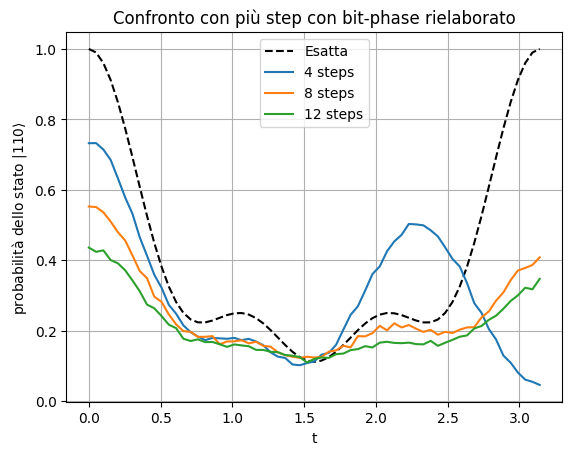

In [33]:
#disegniamo le curve
probs_110_trott = {4:[],8:[],12:[]}
simulator = AerSimulator(noise_model=noise_model)
estimator = BackendEstimator(backend=simulator)
pm = generate_preset_pass_manager(optimization_level=0)
for n in probs_110_trott.keys():
    #evolviamo nel tempo
    for sim_t in ts:
        qc = QuantumCircuit(3)
        #buildiamo lo stato
        qc.x(1)
        qc.x(2)
        
        trott_steps = Heisenberg_Trotter(num_spins=3,trotter_steps=n,t=sim_t)
        
        qc = qc.compose(trott_steps)

        
        isa_circuit = pm.run(qc)
        isa_observable = prj.apply_layout(isa_circuit.layout)
        trotter_result = estimator.run([(isa_circuit, isa_observable)]).result()
        trotter_value = trotter_result[0].data.evs
        probs_110_trott[n].append(trotter_value.mean().real)
        #print(trotter_value.mean().real)
    
    print(str(n)+" steps completed")

#plottiamo
plt.plot(ts, probs_110,linestyle="dashed",color="black",label="Esatta")
for (i,n) in enumerate(probs_110_trott.keys()):
    plt.plot(ts, probs_110_trott[n],color="C"+str(i),label=str(n)+" steps")
plt.xlabel('t')
plt.ylabel(r'probabilità dello stato $|110\rangle$')
plt.title(r'Confronto con più step con bit-phase rielaborato')
plt.legend()
plt.grid()
plt.savefig('../../png/noise2/2_bitphase2.png')
plt.show()

Si osserva che con questo modello tutte le curve hanno subito uno shift verso il basso e dunque si distaccano maggiormente dalla curva esatta, sebbene ancora la curva a 4 steps non venga particolarmente turbata oltre t = 1.5

### ERRORE DI DEPOLARIZING 

Utilizziamo il modello con il bitphase rielaborato e introduciamo una nuova fonte di errore, ovvero il depolarizing. Il depolarizing agisce introducendo sul singolo qubit una probabilità che questo passi ad essere uno stato mixed. A livello di implementazione si utilizzano due channel che simulino l'ambiente. Il primo channel contiene lo stato misto, mentre il terzo stato è una combinazione di uno stato 0 con 1-p e di uno stato 1 con p. Quest'ultimo channel viene usato per controllare che lo stato misto e lo stato di partenza siano stati scambiati o meno. 

La funzione di qiskit-aer richiede in input un parametro e non la probabilità. (vedi documentazione https://qiskit.github.io/qiskit-aer/stubs/qiskit_aer.noise.depolarizing_error.html). 

In [34]:
noise_model = NoiseModel()

cx_depolarizing = 0.001
p_reset = 0.003
p_meas = 0.002
p_gate1 = 0.005

error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)
error_depolarizing = depolarizing_error(cx_depolarizing, 2)

gate2_dep = error_gate2.compose(error_depolarizing)


noise_model.add_all_qubit_quantum_error(error_reset, "reset")
noise_model.add_all_qubit_quantum_error(error_meas, "measure")
noise_model.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
noise_model.add_all_qubit_quantum_error(gate2_dep, ["cx"])

4 steps completed
8 steps completed
12 steps completed


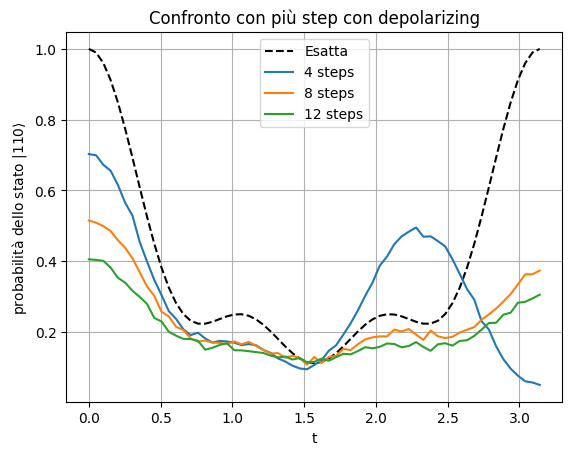

In [35]:
#disegniamo le curve con depolarizing
probs_110_trott = {4:[],8:[],12:[]}
simulator = AerSimulator(noise_model=noise_model)
estimator = BackendEstimator(backend=simulator)
pm = generate_preset_pass_manager(optimization_level=0)
for n in probs_110_trott.keys():
    #evolviamo nel tempo
    for sim_t in ts:
        qc = QuantumCircuit(3)
        #buildiamo lo stato
        qc.x(1)
        qc.x(2)
        
        trott_steps = Heisenberg_Trotter(num_spins=3,trotter_steps=n,t=sim_t)
        
        qc = qc.compose(trott_steps)

        
        isa_circuit = pm.run(qc)
        isa_observable = prj.apply_layout(isa_circuit.layout)
        trotter_result = estimator.run([(isa_circuit, isa_observable)]).result()
        trotter_value = trotter_result[0].data.evs
        probs_110_trott[n].append(trotter_value.mean().real)
        #print(trotter_value.mean().real)
    
    print(str(n)+" steps completed")

#plottiamo
plt.plot(ts, probs_110,linestyle="dashed",color="black",label="Esatta")
for (i,n) in enumerate(probs_110_trott.keys()):
    plt.plot(ts, probs_110_trott[n],color="C"+str(i),label=str(n)+" steps")
plt.xlabel('t')
plt.ylabel(r'probabilità dello stato $|110\rangle$')
plt.title(r'Confronto con più step con depolarizing')
plt.legend()
plt.grid()
plt.savefig('../../png/noise2/3_depolarizing.png')
plt.show()

### ERRORE DI AMPLITUDE DAMPING

L'amplitude damping simula gli effetti di una dissipazione dell'energia del sistema con l'ambiente. Nel caso di approssimazione in cui consideriamo la temperatura allo zero assoluto, dipende da un parametro $\gamma = sin^2 (\theta)$ con $\theta$ un angolo randomico applicato come rotazione Ry($\frac{\theta}{2}$). https://qiskit.github.io/qiskit-aer/stubs/qiskit_aer.noise.amplitude_damping_error.html

In [36]:
noise_model = NoiseModel()

gamma_amplitude = 0.01
cx_depolarizing = 0.001
p_reset = 0.003
p_meas = 0.002
p_gate1 = 0.005

error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)
error_depolarizing = depolarizing_error(cx_depolarizing, 2)
error_amplitude_damp = amplitude_damping_error(gamma_amplitude)

gate2_dep = error_gate2.compose(error_depolarizing)
gate1_ampl = error_gate1.compose(error_amplitude_damp)


noise_model.add_all_qubit_quantum_error(error_reset, "reset")
noise_model.add_all_qubit_quantum_error(error_meas, "measure")
noise_model.add_all_qubit_quantum_error(gate1_ampl, ["u1", "u2", "u3"])
noise_model.add_all_qubit_quantum_error(gate2_dep, ["cx"])

4 steps completed
8 steps completed
12 steps completed


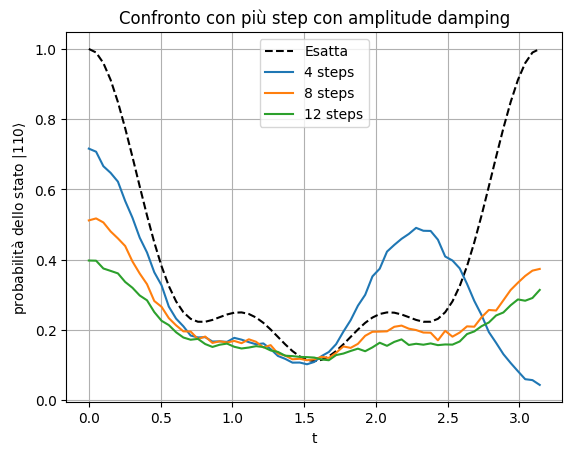

In [37]:
#disegniamo le curve con amplitude damping
probs_110_trott = {4:[],8:[],12:[]}
simulator = AerSimulator(noise_model=noise_model)
estimator = BackendEstimator(backend=simulator)
pm = generate_preset_pass_manager(optimization_level=0)
for n in probs_110_trott.keys():
    #evolviamo nel tempo
    for sim_t in ts:
        qc = QuantumCircuit(3)
        #buildiamo lo stato
        qc.x(1)
        qc.x(2)
        
        trott_steps = Heisenberg_Trotter(num_spins=3,trotter_steps=n,t=sim_t)
        
        qc = qc.compose(trott_steps)

        
        isa_circuit = pm.run(qc)
        isa_observable = prj.apply_layout(isa_circuit.layout)
        trotter_result = estimator.run([(isa_circuit, isa_observable)]).result()
        trotter_value = trotter_result[0].data.evs
        probs_110_trott[n].append(trotter_value.mean().real)
        #print(trotter_value.mean().real)
    
    print(str(n)+" steps completed")

#plottiamo
plt.plot(ts, probs_110,linestyle="dashed",color="black",label="Esatta")
for (i,n) in enumerate(probs_110_trott.keys()):
    plt.plot(ts, probs_110_trott[n],color="C"+str(i),label=str(n)+" steps")
plt.xlabel('t')
plt.ylabel(r'probabilità dello stato $|110\rangle$')
plt.title(r'Confronto con più step con amplitude damping')
plt.legend()
plt.grid()
plt.savefig('../../png/noise2/4_amplitudedamping.png')
plt.show()

### ERRORE DI AMPLITUDE + PHASE DAMPING

Il Phase Damping è un errore legato alla perdita di informazione quantistica senza perdita d'energia ed è legato ad un "phase kick", ovvero una rotazione di Rz di $\theta$ con $\theta$ variabile random distribuita in modo gaussiano con la media in 0 e la varianza di $2\lambda$

In [38]:
noise_model = NoiseModel()

gamma_phase = 0.01
gamma_amplitude = 0.01
cx_depolarizing = 0.001
p_reset = 0.003
p_meas = 0.002
p_gate1 = 0.005

error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)
error_depolarizing = depolarizing_error(cx_depolarizing, 2)
error_amplitude_damp = amplitude_damping_error(gamma_amplitude)
error_phase_damp = phase_damping_error(gamma_phase)

gate2_dep = error_gate2.compose(error_depolarizing)
ampl_phase = error_amplitude_damp.compose(error_phase_damp)
gate1_ampl_phase = error_gate1.compose(ampl_phase)



noise_model.add_all_qubit_quantum_error(error_reset, "reset")
noise_model.add_all_qubit_quantum_error(error_meas, "measure")
noise_model.add_all_qubit_quantum_error(gate1_ampl_phase, ["u1", "u2", "u3"])
noise_model.add_all_qubit_quantum_error(gate2_dep, ["cx"])

4 steps completed
8 steps completed
12 steps completed


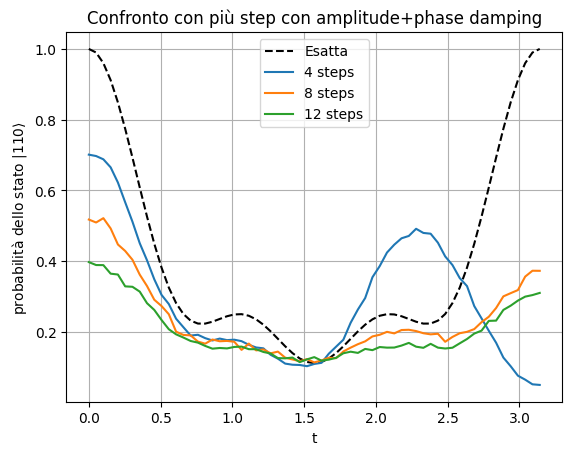

In [39]:
#disegniamo le curve con amplitude damping
probs_110_trott = {4:[],8:[],12:[]}
simulator = AerSimulator(noise_model=noise_model)
estimator = BackendEstimator(backend=simulator)
pm = generate_preset_pass_manager(optimization_level=0)
for n in probs_110_trott.keys():
    #evolviamo nel tempo
    for sim_t in ts:
        qc = QuantumCircuit(3)
        #buildiamo lo stato
        qc.x(1)
        qc.x(2)
        
        trott_steps = Heisenberg_Trotter(num_spins=3,trotter_steps=n,t=sim_t)
        
        qc = qc.compose(trott_steps)

        
        isa_circuit = pm.run(qc)
        isa_observable = prj.apply_layout(isa_circuit.layout)
        trotter_result = estimator.run([(isa_circuit, isa_observable)]).result()
        trotter_value = trotter_result[0].data.evs
        probs_110_trott[n].append(trotter_value.mean().real)
        #print(trotter_value.mean().real)
    
    print(str(n)+" steps completed")

#plottiamo
plt.plot(ts, probs_110,linestyle="dashed",color="black",label="Esatta")
for (i,n) in enumerate(probs_110_trott.keys()):
    plt.plot(ts, probs_110_trott[n],color="C"+str(i),label=str(n)+" steps")
plt.xlabel('t')
plt.ylabel(r'probabilità dello stato $|110\rangle$')
plt.title(r'Confronto con più step con amplitude+phase damping')
plt.legend()
plt.grid()
plt.savefig('../../png/noise2/5_amplitude_phase.png')
plt.show()